# Scientific Computing: Diffusion Limited Aggregation and Reaction Diffusion

## Imports

In [1]:
import numpy as np
from IPython.display import HTML
import pickle as pkl
import os
from IPython.display import Image, display

# concentration based DLA solution
import src.solutions.concentrations_DLA as solutions_DLA

# monte carlo DLA solution
import src.solutions.monte_carlo_DLA as solutions_DLA_mc

# gray scott reaction diffusion model
import src.solutions.gray_scott as solutions_gs


import src.visualizations as visualizations

In [2]:
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from matplotlib.animation import FuncAnimation


## A: Diffusion Limited Aggregation

### Parameter Values

In [3]:

N = 100
eta = 1
tol = 1e-4
maxiters = 10000
omega = 1.8
cluster_size = 750
etas = [0.3, 0.5, 0.7, 1, 1.3]
omegas = np.linspace(1.4, 2, 7)
omegas = np.delete(omegas, -1)

grid_indices = np.arange(N*N)
itertjes = 1500
np.round(omegas,1)

# optimal omegas, determined with experimentation
opp_omm = [1.5, 1.6, 1.6, 1.6, 1.7]
opt_omegas = dict()
for i, e in enumerate(etas):
    opt_omegas[e] = opp_omm[i]

### Initialization
creating an initial grid by placing object at the bottom of the 2D grid.   
The grid has a source at the top of the grid.   
within SOR, being part of the object is resembled with concentration of 0

In [4]:
object_grid = solutions_DLA.place_objects(N)
grid = solutions_DLA.initialize_grid(N, object_grid)
iters, grid = solutions_DLA.parallel_SOR(grid, tol, maxiters, omega, object_grid)
assert iters < maxiters, f"No convergence for SOR, omega: {omega} "

### Animation of the DLA Process for Different Eta Values
run the DLA by solving the Laplace formula of the grid,  
calculating the cell connection probabilities with each cell concentration,  
and by selecting potential new cells joining the object (north, east, south, west) neighbors of the object. 
Update the grid by adding the selected cell to the object and rerunning these steps. 

Visualization of this process is provided here. 

#### generate simulation (animation can also be found in plots file)

In [ ]:
# use neutral omega value to reconfigure first grid 
if omega != 1.7:
    omega = 1.7
    iters, grid = solutions_DLA.parallel_SOR(grid, tol, maxiters, omega, object_grid)     
    assert iters < maxiters, f"No convergence for SOR, omega: {omega} "

# copy initial grid to save computation time for all 5 subgaphs (different eta values)
iter_grid_list = [np.copy(grid) for _ in range(5)]
object_grid_list = [np.copy(object_grid) for _ in range(5)]


# generate the initial neighbors that can be chosen to add to the object (copy 5 times as well)
stencil_iter = solutions_DLA.generate_stencil(object_grid_list[0])
stencil_list = [np.copy(stencil_iter) for _ in range(5)]
seedje = 22

# render visualization (updates are done dynamically)
ani = visualizations.animate_1a(iter_grid_list, stencil_list, object_grid_list, grid_indices, etas, seedje, tol, maxiters, opt_omegas, itertjes=1500)


#### Visualize animation

In [ ]:
# visualize within notebook
%matplotlib inline
saved_anim = "plots/2D_diffusion.gif"
HTML(f'<img src="{saved_anim}" style="width: 600px;">')

### Computation of the average number of iterations for a SOR convergence step for Different Omega Values (Run Over 10 Different Grids )

In [ ]:
itertjes = 750
seedje=22

eta_lijstje, grid_lijstje, all_itertjes = solutions_DLA.optimize_omega_DLA(itertjes, etas, seedje, omegas, grid, object_grid, tol, maxiters, grid_indices)

### Visualization of Average Iterations for Each SOR Convergence Step for Different Omega Values

In [ ]:
best_omegas = visualizations.plot_omega_vs_iterations(omegas, all_itertjes)
for eetje, ommetje in best_omegas.items():
    print(f"For eta:  {eetje},  the optimal omega is {np.round(ommetje, 1)} ")

### Comparison sequential vs Parallel implementation of SOR 
This is done for eta value 1, and cluster size 750

In [ ]:

# with eta is 1
sr_val = (tol, maxiters, opt_omegas[1])
parallel_time, sequential_time, _, _ = solutions_DLA.speedup_par_seq(grid, object_grid, sr_val, grid_indices, 750, etatje=1)

print(f"Parallel execution time: {parallel_time:.4f} seconds")
print(f"Sequential execution time: {sequential_time:.4f} seconds")
print(f"Speedup: {sequential_time / parallel_time:.2f}x")

### Visualization of Clusters for Different Eta Values

In [ ]:
visualizations.plot_five_DLA(grid_lijstje, etas)

## B. Implemention of the Monte Carlo version of DLA + comparison of the resulting cluster to those obtained with the diffusion equation.

In [4]:
# Initial parameters for the DLA simulation using random walkers
N = 100
cluster_size = 750
p_join_standard = 1.0

# Evolution of diffusion using random walkers

file_path = "data/all_grids2.pkl"
# Load the data if it exists else run the simulation
if os.path.exists(file_path):
    try:
        with open(file_path, "rb") as f:
            all_grids = pkl.load(f)
    except EOFError:
        print("EOFError: existing data not found, will run simulation")
else:
    all_grids = solutions_DLA_mc.monte_carlo_dla(N, p_join_standard, cluster_size, animation=True)

animation = visualizations.animate_mc_dla(all_grids)

In [ ]:
gif_path = "plots/animation_random_walker.gif"

# Display the GIF
display(Image(filename=gif_path))

## C. Generating the simulation for Monte Carlo DLA for different values of ps and visualized the results
for a cluster size of 750

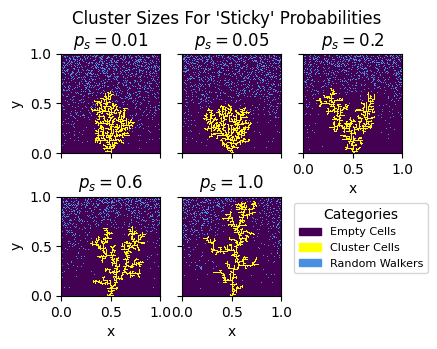

In [2]:
N = 100
cluster_size = 750
probs = [0.01, 0.05, 0.2, 0.6, 1.0]
probs_grids = []
save_prob_grids = False
seed = 22

# Existing data file, re-running takes approximately 30 minutes
file_path = "data/probabilities_grids.pkl"

if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        probs_grids = pkl.load(f)
        #print(probs_grids)
else:
    for prob in probs:
        grids = solutions_DLA_mc.monte_carlo_dla(N, prob, cluster_size, seed)
        probs_grids.append(grids[0])

if save_prob_grids:
    with open(file_path, "wb") as f:
        pkl.dump(probs_grids, f)


visualizations.visualize_for_different_probs(probs_grids, probs)

## D. Implementation of the Gray-Scott model in 2D with periodic boundary conditions for a N x N grid 
The implementation is parallelized over rows for the Laplace equation used. For initial conditions, u = 0.5 is taken everywhere in the system, v = 0.25 is taken in a small square in the center of the system.  
 A small amount of noise is added in the center of the system for both U and V. The resulting concentration of U is plotted for different parameter values. 

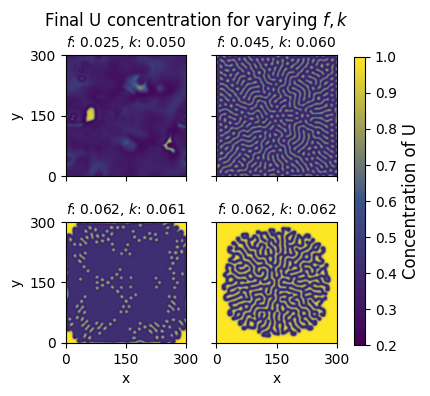

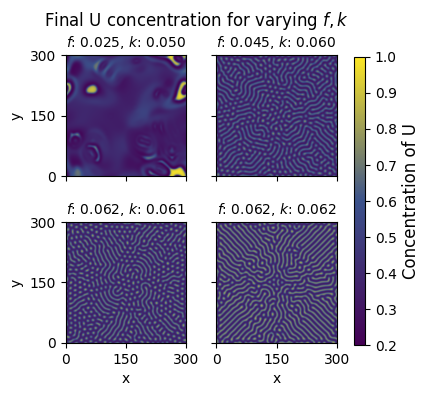

In [3]:
# parameters
N = 300  # grid size
num_steps = 15000  # number of time steps
dt = 1 # time step size
dx = 1 # grid spacing
noise_level = 0.01 # noise level
output_dir = "plots" # output directory for plots
seed = 22

# parameter sets for f (first) and k (second) - 1
param_sets_f_k = [
    (0.025, 0.050),
    (0.045, 0.060),
    (0.062, 0.061),
    (0.062, 0.062)
]

# first figure below

# first diffusion coefficient pairs
param_sets_Du_Dv_1 = (0.16, 0.08)

# store final results of U concentration for plotting
u_final_list_1 = []

# iterate through f and k values
for f, k in param_sets_f_k:
    Du_1, Dv_1 = param_sets_Du_Dv_1 # test for Du=0.16, Dv=0.08
    u_final_1, _ = solutions_gs.run_simulation_gray_scott(N, num_steps, dt, dx, Du_1, Dv_1, f, k, noise_level, seed)
    u_final_list_1.append(u_final_1)

# plot the final concentrations of U for the tested parameter sets
visualizations.plot_final_gray_scott(u_final_list_1, param_sets_f_k, N, output_dir, plot_number=1)

# second figure below

# second diffusion coefficient pairs
param_sets_Du_Dv_2 = (0.20, 0.08)

# store final results of U concentration for plotting
u_final_list_2 = []

# iterate through f and k values
for f, k in param_sets_f_k:
    Du_2, Dv_2 = param_sets_Du_Dv_2 # test for Du=0.20, Dv=0.08
    u_final_2, _ = solutions_gs.run_simulation_gray_scott(N, num_steps, dt, dx, Du_2, Dv_2, f, k, noise_level, seed)
    u_final_list_2.append(u_final_2)

# plot the final concentrations of U for the tested parameter sets
visualizations.plot_final_gray_scott(u_final_list_2, param_sets_f_k, N, output_dir, plot_number=2)